**Table of contents**<a id='toc0_'></a>    
- [Isolation Forest Anomaly Detection System](#toc1_)    
  - [**Simulating Payment Dataset**](#toc1_1_)    
    - [**Data Stream Simulation**](#toc1_1_1_)    
    - [**Data Insights**](#toc1_1_2_)    
      - [**1. Distribution of `receiver_balance_before` and `amount`:**](#toc1_1_2_1_)    
      - [**2. Relation between `receiver_balance_before` and `transaction amount`:**](#toc1_1_2_2_)    
      - [**3. Visualizing Seasonality in Generated Data:**](#toc1_1_2_3_)    
  - [**Algorithm: Isolation Forest**](#toc1_2_)    
  - [**Results and Discussion**](#toc1_3_)    
    - [**1. Distribution of `receiver_balance_before` and `amount` (Normal vs Anomalous):**](#toc1_3_1_)    
    - [**2. Receiver Balance vs. Transaction Amount (Normal vs Anomalous)**](#toc1_3_2_)    
    - [**3. Anomaly Detection in Real-Time Data Stream**](#toc1_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Isolation Forest Anomaly Detection System](#toc0_)

In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

## <a id='toc1_1_'></a>[**Simulating Payment Dataset**](#toc0_)

This project demonstrates a real-time anomaly detection system using the Isolation Forest algorithm. In this section, we simulate a financial data stream with **seasonality** and **noise**, and the system is designed to identify unusual data patterns (anomalies) in real-time.  

### <a id='toc1_1_1_'></a>[**Data Stream Simulation**](#toc0_)
The data stream simulates a real-world financial metric. It incorporates:
- **Seasonality**: Regular patterns observed over time (e.g., daily or weekly cycles)
- **Random Noise**: Unpredictable fluctuations, added to mimic real-life volatility
- **Anomalies**: Injected high or low values representing potential outliers in the stream

In [29]:
# Function to generate correlated exponential data
def generate_correlated_exponential(num_points, correlation_coefficient=0.2):
    """
    This is used as a helper function to generate correlated exponential data.
    
    Parameters:
    - num_points: Number of data points to generate.
    - correlation_coefficient: Correlation coefficient between the two variables.
    
    Returns:
    - x_correlated: Correlated exponential data for x.
    - y_correlated: Correlated exponential data for y.
    """
    # Generate independent exponential random variables
    x = np.random.exponential(size=num_points)
    y = np.random.exponential(size=num_points)

    # Covariance matrix for correlation
    covariance_matrix = np.array([[1, correlation_coefficient], [correlation_coefficient, 1]])

    # Apply the correlation
    scale = 0.3
    correlated_data = np.random.multivariate_normal([0, 0], covariance_matrix, size=num_points)
    x_correlated = np.exp(scale * correlated_data[:, 0])
    y_correlated = np.exp(scale * correlated_data[:, 1])

    return x_correlated, y_correlated

# Function to simulate a payment dataset using correlated exponential distribution
def generate_payment_data(num_transactions=1000, days=30):
    """
    Generate a payment dataset with correlated balances and amounts, including seasonality.
    
    Parameters:
    - num_transactions: Number of transactions to generate.
    - days: Number of days in the time span for the dataset.
    
    Returns:
    - DataFrame containing simulated transaction data.
    """
    # Define transaction types
    transaction_types = ['TRANSFER', 'CASH_OUT', 'DEPOSIT', 'PAYMENT']
    
    # Time span for the dataset
    end_time = datetime.now()
    start_time = end_time - timedelta(days=days)

    # Lists to store transaction data
    data = []

    # Generate correlated receiver_balance_before and amount
    receiver_balances, amounts = generate_correlated_exponential(num_transactions)

    # Scale the values to appropriate balance and amount ranges
    receiver_balances = receiver_balances * np.random.uniform(500, 50000)
    amounts = amounts * np.random.uniform(5, 5000)

    # Seasonality effect
    time_effect = np.linspace(0, 2 * np.pi, num_transactions)
    seasonality_factor = 1 + 0.5 * np.sin(time_effect)  # Sinusoidal seasonal pattern

    # Apply seasonal factor to balances and amounts
    receiver_balances = receiver_balances * seasonality_factor
    amounts = amounts * seasonality_factor

    # Simulate each transaction
    for i in range(num_transactions):
        # Choose random transaction type
        tx_type = np.random.choice(transaction_types)
        
        receiver_balance_before = receiver_balances[i]
        amount = min(amounts[i], receiver_balance_before)

        # Generate sender's balance as random
        sender_balance_before = np.random.uniform(500, 100000)

        # Adjust sender's and receiver's balances after transaction
        if tx_type != 'DEPOSIT':
            receiver_balance_after = receiver_balance_before + amount
            sender_balance_after = sender_balance_before - amount
        else:
            receiver_balance_after = receiver_balance_before - amount
            sender_balance_after = sender_balance_before + amount

        # Append transaction data
        data.append({
            'transaction_type': tx_type,
            'sender_balance_before': sender_balance_before,
            'sender_balance_after': sender_balance_after,
            'receiver_balance_before': receiver_balance_before,
            'receiver_balance_after': receiver_balance_after,
            'amount': amount,
            'transaction_time': start_time + timedelta(seconds=np.random.randint(0, int((end_time - start_time).total_seconds())))
        })

    return pd.DataFrame(data)

# Generate transaction data
transaction_data = generate_payment_data(num_transactions=3000)

### <a id='toc1_1_2_'></a>[**Data Insights**](#toc0_)

Before applying the Isolation Forest model to detect anomalies, it’s essential to extract and analyze key insights from the generated data. These insights not only help in understanding the underlying patterns but also improve the anomaly detection process by providing a more informed approach.

#### <a id='toc1_1_2_1_'></a>[**1. Distribution of `receiver_balance_before` and `amount`:**](#toc0_)

Plotting the distribution helps in understanding the concentration of balances and transaction amounts. It can show if the data has a normal or skewed distribution.

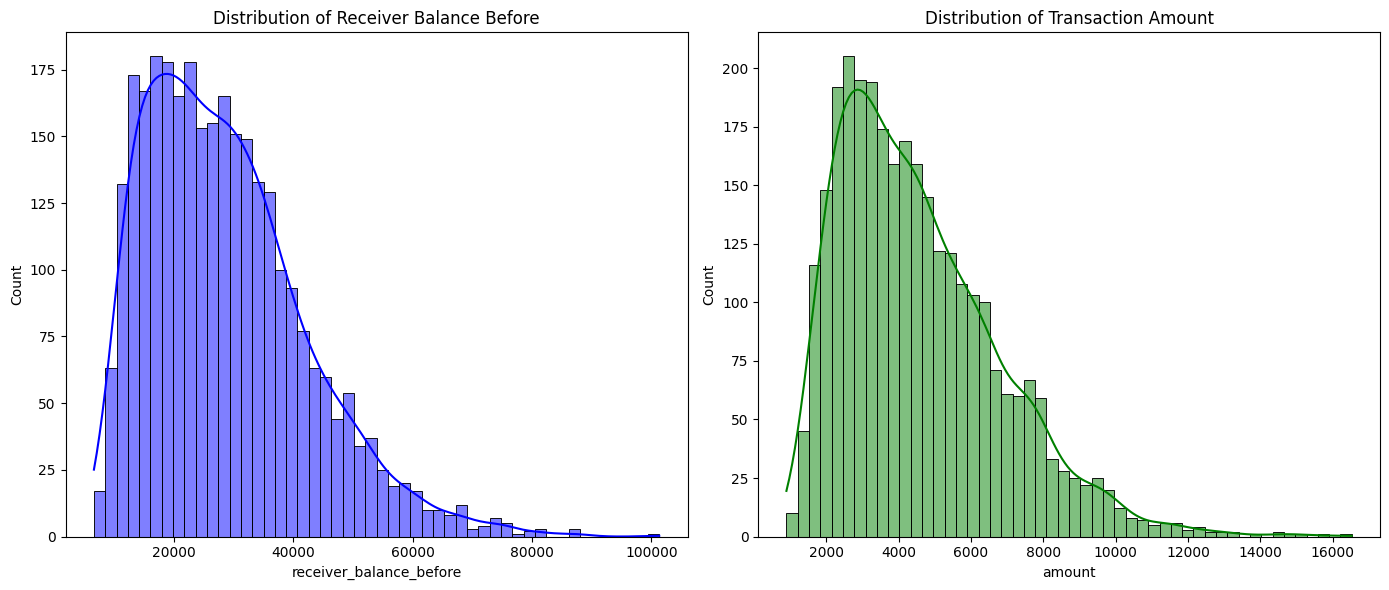

In [30]:
# Plot distribution of receiver_balance_before and amount
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(transaction_data['receiver_balance_before'], bins=50, kde=True, color='blue')
plt.title('Distribution of Receiver Balance Before')

plt.subplot(1, 2, 2)
sns.histplot(transaction_data['amount'], bins=50, kde=True, color='green')
plt.title('Distribution of Transaction Amount')

plt.tight_layout()
plt.show()

**What we learn**:  
- **Dense Clusters**: Most balances and amounts are concentrated in the lower range, it shows that smaller transactions are more common.
- **Outliers**: There are a few points far away from the main cluster, they could represent potential anomalies or unusual transactions.

#### <a id='toc1_1_2_2_'></a>[**2. Relation between `receiver_balance_before` and `transaction amount`:**](#toc0_)

The scatter plot reveals the relationship between `receiver_balance_before` and `transaction amount`. The plot helps visualize the distribution of the data and provides context for outlier detection. This is critical for the Isolation Forest algorithm, which identifies anomalies based on how easily a point can be isolated. In this case, an anomaly could be a transaction amount that deviates significantly from the norm given the initial balance.

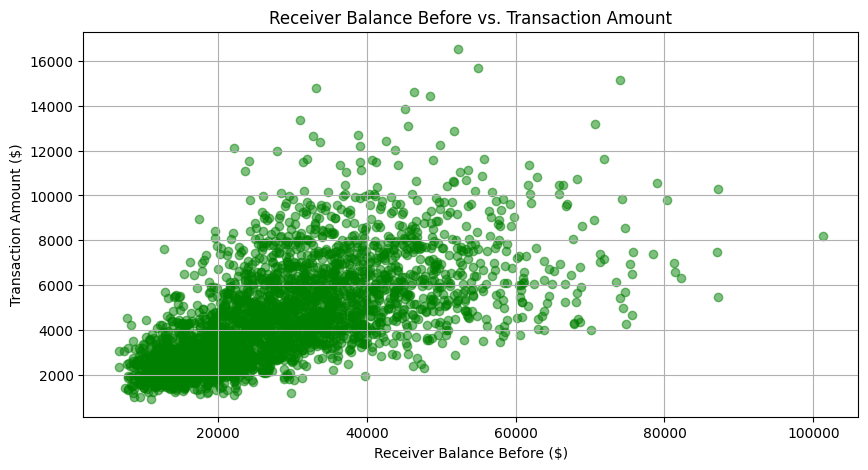

In [31]:
# Scatter plot between receiver_balance_before and transaction amount
plt.figure(figsize=(10, 5))
plt.scatter(transaction_data['receiver_balance_before'], transaction_data['amount'], alpha=0.5, color='green')
plt.title('Receiver Balance Before vs. Transaction Amount')
plt.xlabel('Receiver Balance Before ($)')
plt.ylabel('Transaction Amount ($)')
plt.grid(True)
plt.show()

#### <a id='toc1_1_2_3_'></a>[**3. Visualizing Seasonality in Generated Data:**](#toc0_)

By plotting the values against time, we can clearly observe the peaks and troughs in the data that correspond to different "seasons" or periods of higher/lower transaction amounts and balances.

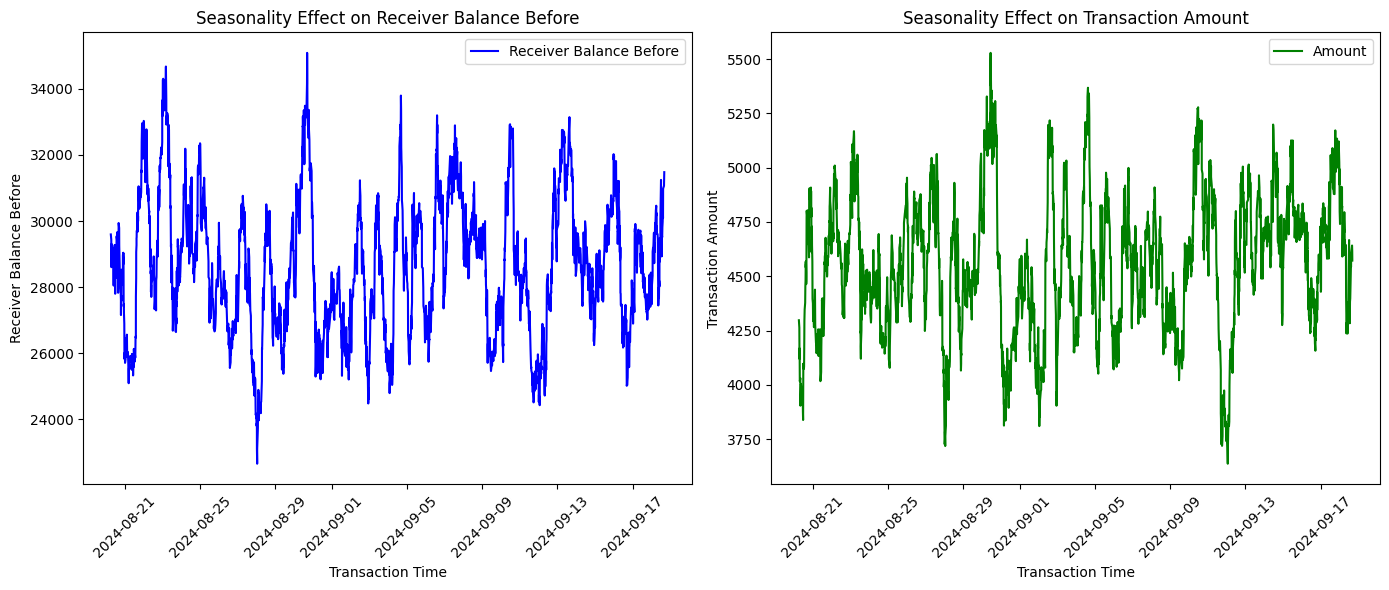

In [32]:
# Function to visualize seasonality in transaction data
def visualize_seasonality(df):
    """
    Visualize the seasonality effect on receiver balance and transaction amount.
    
    Parameters:
    - df: DataFrame containing transaction data.
    """
    # Sort transactions by time
    df_sorted = df.sort_values(by='transaction_time')

    # Apply rolling mean to smooth out the spikes
    window_size = 50
    df_sorted['receiver_balance_smooth'] = df_sorted['receiver_balance_before'].rolling(window=window_size).mean()
    df_sorted['amount_smooth'] = df_sorted['amount'].rolling(window=window_size).mean()

    # Plot receiver_balance_before and amount against time
    plt.figure(figsize=(14, 6))

    # Receiver balance plot
    plt.subplot(1, 2, 1)
    plt.plot(df_sorted['transaction_time'], df_sorted['receiver_balance_smooth'], label='Receiver Balance Before', color='blue')
    plt.xlabel('Transaction Time')
    plt.ylabel('Receiver Balance Before')
    plt.title('Seasonality Effect on Receiver Balance Before')
    plt.xticks(rotation=45)
    plt.legend()

    # Amount plot
    plt.subplot(1, 2, 2)
    plt.plot(df_sorted['transaction_time'], df_sorted['amount_smooth'], label='Amount', color='green')
    plt.xlabel('Transaction Time')
    plt.ylabel('Transaction Amount')
    plt.title('Seasonality Effect on Transaction Amount')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize seasonality
visualize_seasonality(transaction_data)

**What we learn**:  
- The **balances** and the **amounts** oscillate due to the seasonal factor.

---

## <a id='toc1_2_'></a>[**Algorithm: Isolation Forest**](#toc0_)

Isolation Forest is an outlier detection method that isolates observations by randomly selecting a feature and a split value. Anomalies are expected to be isolated faster than normal points, making the algorithm efficient for large datasets.  

In this section, we apply Isolation Forest in a real-time scenario to detect anomalies in a continuously evolving data stream.

In [33]:
# Select relevant features for anomaly detection
features = ['sender_balance_before', 'receiver_balance_before', 'amount']

# Apply StandardScaler to standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(transaction_data[features])

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(df_scaled)

# Predict the anomalies (1 = normal, -1 = anomaly)
transaction_data['anomaly'] = iso_forest.predict(df_scaled)

# Convert anomaly labels to binary (0 = normal, 1 = anomaly)
transaction_data['anomaly'] = transaction_data['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Show the number of anomalies detected
print(transaction_data['anomaly'].value_counts())

anomaly
0    2850
1     150
Name: count, dtype: int64


---

## <a id='toc1_3_'></a>[**Results and Discussion**](#toc0_)

### <a id='toc1_3_1_'></a>[**1. Distribution of `receiver_balance_before` and `amount` (Normal vs Anomalous):**](#toc0_)

The feature distribution plots for `receiver_balance_before` and `transaction amount` visually highlight the contrast between **normal** and **anomalous** transactions. For `receiver_balance_before`, the distribution of normal transactions is smoother, while anomalies exhibit more sparse and irregular distribution, indicating that anomalies are often associated with extreme or unusual balances. Similarly, for `transaction amount`, normal transactions cluster around typical values, whereas anomalous transactions tend to be more spread, suggesting that anomalies typically involve unusually high or low amounts.

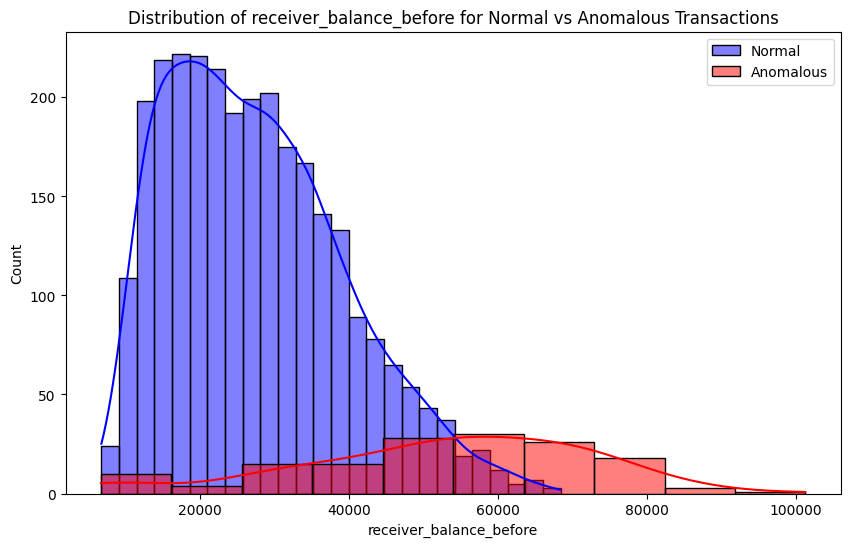

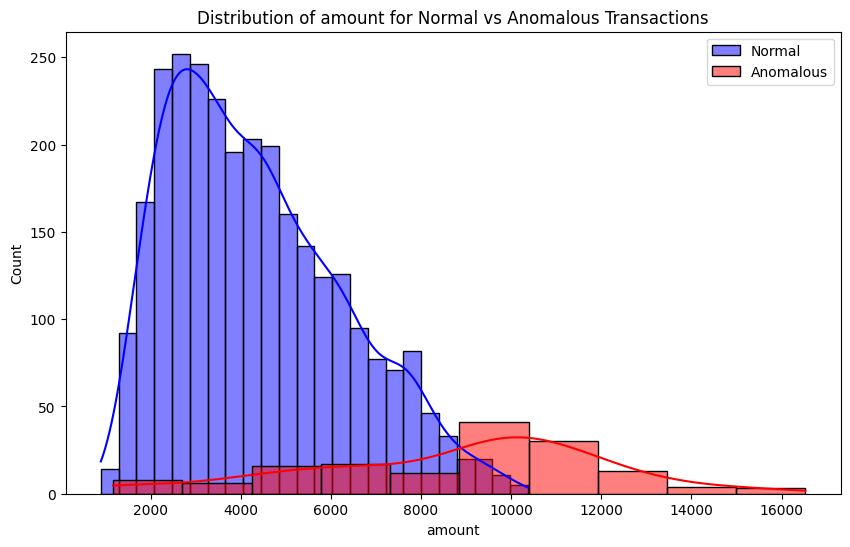

In [34]:
# Function to plot feature distribution for normal vs anomalous transactions
def plot_feature_distribution(df, feature):
    """
    Plot distribution of a feature for normal vs anomalous transactions.
    
    Parameters:
    - df: DataFrame containing transaction data.
    - feature: The feature to plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot distribution of the feature for normal transactions
    sns.histplot(df[df['anomaly'] == 0][feature], color='blue', label='Normal', kde=True)
    
    # Plot distribution of the feature for anomalous transactions
    sns.histplot(df[df['anomaly'] == 1][feature], color='red', label='Anomalous', kde=True)
    
    plt.title(f'Distribution of {feature} for Normal vs Anomalous Transactions')
    plt.legend()
    plt.show()

# Call the function for specific features
plot_feature_distribution(transaction_data, 'receiver_balance_before')
plot_feature_distribution(transaction_data, 'amount')

### <a id='toc1_3_2_'></a>[**2. Receiver Balance vs. Transaction Amount (Normal vs Anomalous)**](#toc0_)

This scatter plot illustrates the relationship between `receiver_balance_before` and `transaction amount`, with separate markers for normal and anomalous transactions. Normal transactions appear clustered in certain regions, showing typical transaction patterns. In contrast, anomalous transactions (in red) are more scattered and tend to deviate from the expected behavior, with points that lie further from the clusters, indicating potential outliers. **The plot effectively visualizes how the Isolation Forest model distinguishes normal and anomalous behavior by identifying these deviations.**

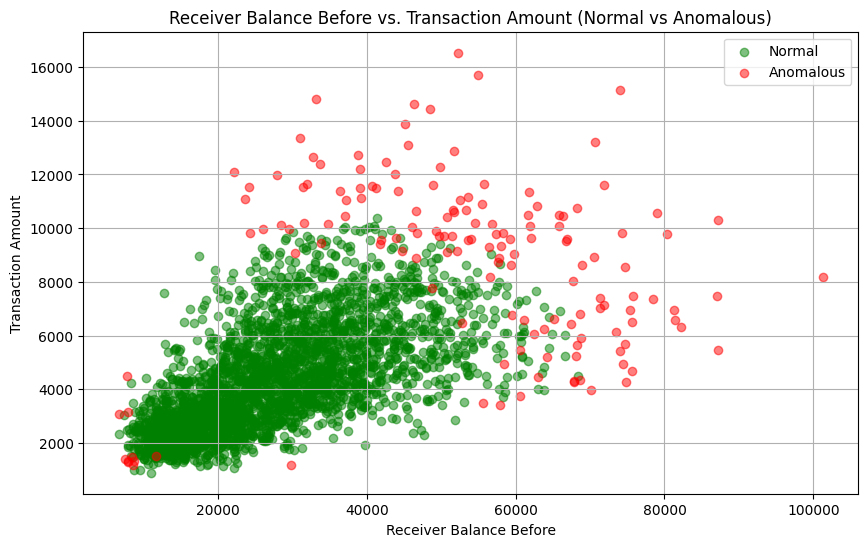

In [35]:
# Function to plot balance vs amount for normal vs anomalous transactions
def plot_balance_vs_amount(df):
    """
    Plot receiver balance before vs transaction amount for normal vs anomalous transactions.
    
    Parameters:
    - df: DataFrame containing transaction data.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot normal transactions
    plt.scatter(df[df['anomaly'] == 0]['receiver_balance_before'], 
                df[df['anomaly'] == 0]['amount'], 
                color='green', label='Normal', alpha=0.5)
    
    # Plot anomalous transactions
    plt.scatter(df[df['anomaly'] == 1]['receiver_balance_before'], 
                df[df['anomaly'] == 1]['amount'], 
                color='red', label='Anomalous', alpha=0.5)
    
    plt.xlabel('Receiver Balance Before')
    plt.ylabel('Transaction Amount')
    plt.title('Receiver Balance Before vs. Transaction Amount (Normal vs Anomalous)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot balance vs amount
plot_balance_vs_amount(transaction_data)


### <a id='toc1_3_3_'></a>[**3. Anomaly Detection in Real-Time Data Stream**](#toc0_)
This plot visualizes the real-time data stream with anomalies detected using the Isolation Forest algorithm. Red markers indicate outliers, which are flagged by the model.

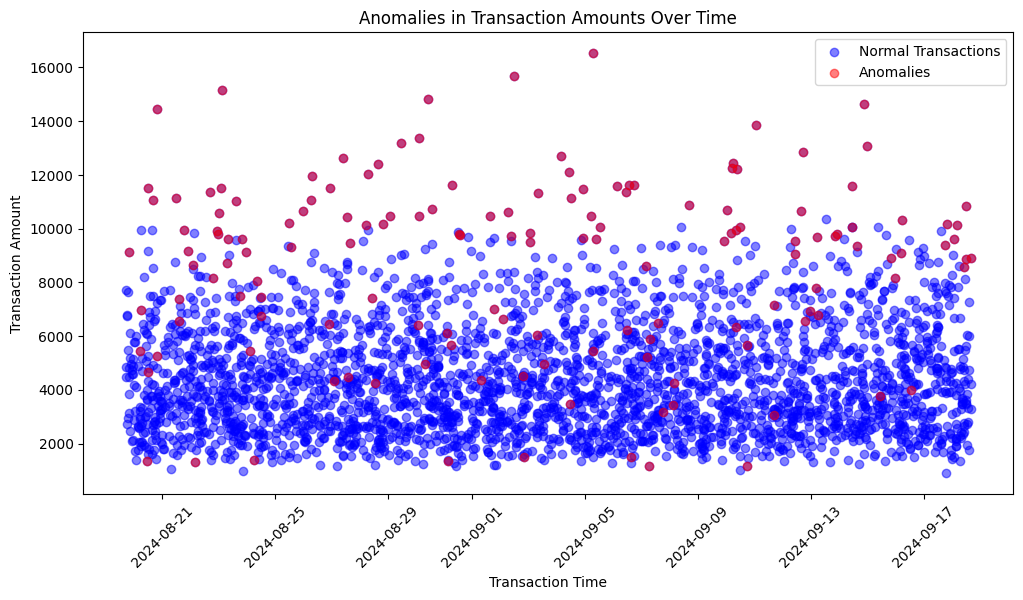

In [36]:
# Function to plot anomalies over time
def plot_anomalies_over_time(df):
    """
    Plot anomalies in transaction amounts over time.
    
    Parameters:
    - df: DataFrame containing transaction data.
    """
    # Sort the data by transaction time
    df_sorted = df.sort_values(by='transaction_time')

    # Plot normal transactions and anomalies over time
    plt.figure(figsize=(12, 6))
    plt.scatter(df_sorted['transaction_time'], df_sorted['amount'], label='Normal Transactions', color='blue', alpha=0.5)
    plt.scatter(df_sorted[df_sorted['anomaly'] == 1]['transaction_time'], df_sorted[df_sorted['anomaly'] == 1]['amount'], label='Anomalies', color='red', alpha=0.5)
    plt.xlabel('Transaction Time')
    plt.ylabel('Transaction Amount')
    plt.title('Anomalies in Transaction Amounts Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Call the function to plot anomalies
plot_anomalies_over_time(transaction_data)